# Fermipy tutorial

This tutorial shows how to perform Fermi-LAT analysis with the Fermipy Python package. 
Many parts of this tutorial are taken directly from the documentation page of Fermipy: [fermipy.readthedocs](http://fermipy.readthedocs.io/en/latest/).
I suggest to go directly to the documentation page to find further informations.

Fermipy is a python package created by Mattew Wood that facilitates analysis of data from the Large Area Telescope (LAT) with the Fermi Science Tools.
The Fermipy package is built on the pyLikelihood interface of the Fermi Science Tools and provides a set of high-level tools for performing common analysis tasks:
* Data and model preparation with the gt-tools (gtselect, gtmktime, etc.).
* Extracting a spectral energy distribution (SED) of a source.
* Generating TS and residual maps for a region of interest.
* Finding new source candidates.
* Localizing a source or fitting its spatial extension.

# Installation

Instruction on how to install in SLAC machines or in your laptop Fermipy are available at this page: [fermipy.installation](http://fermipy.readthedocs.io/en/latest/install.html)
Fermipy is only compatible with Science Tools v10r0p5 or later. If you are using an earlier version, you will need to download and install the latest version from the [FSSC](https://fermi.gsfc.nasa.gov/ssc/). Note that it is recommended to use the non-ROOT binary distributions of the Science Tools. These instructions assume that you already have a local installation of the Fermi Science Tools (STs). For more information about installing and setting up the STs see Installing the Fermi Science Tools.

Running at SLAC

This section provides specific installation instructions for running in the SLAC computing environment. First download and source the slacsetup.sh script:

To initialize the ST environment run the slacsetup function:

This will setup your GLAST_EXT path and source the setup script for one of the pre-built ST installations (the current default is 11-05-00). To manually override the ST version you can provide the release tag as an argument to slacsetup:

Because users don’t have write access to the ST python installation all pip commands that install or uninstall packages must be executed with the --user flag. After initializing the STs environment, install fermipy with pip:

This will install fermipy in $HOME/.local. You can verify that the installation has succeeded by importing GTAnalysis:

# Configuration file:

The first step is to compose a configuration file that defines the data selection and analysis parameters. Fermipy uses YAML files to read and write its configuration in a persistent format. The configuration file has a hierarchical structure that groups parameters into dictionaries that are keyed to a section name (data, binning, etc.). Below I report a sample of configuration applied for an analysis of the SMC:

The configuration file has the same structure as the configuration dictionary such that one can read/write configurations using the load/dump methods of the yaml module:

The data section defines the input data set and spacecraft file for the analysis. Here evfile points to a list of FT1 files that encompass the chosen ROI, energy range, and time selection.
The parameters in the binning section define the dimensions of the ROI and the spatial and energy bin size.
The selection section defines parameters related to the data selection (energy range, zmax cut, and event class/type). The target parameter in this section defines the ROI center to have the same coordinates as the given source.
The model section defines parameters related to the ROI model definition (diffuse templates, point sources).
Fermipy gives the user the option to combine multiple data selections into a joint likelihood with the components section. For more informations on this visit: http://fermipy.readthedocs.io/en/latest/quickstart.html

Note that the setup for a joint analysis is identical to the above except for the modification to the components section.  The following example shows the components configuration one would use to define a joint analysis with the four PSF event types:
```python
components:
  - { selection : { evtype : 4  } }
  - { selection : { evtype : 8  } }
  - { selection : { evtype : 16 } }
  - { selection : { evtype : 32 } }
```

# Start your run

First of all you need to load the configuration file, create the object gta and run the tool gta.setup that implements the ST gtselect, gtmktime, gtbin, gtexpcube, gtsrcmap tools

In [18]:
import os
import numpy as np
from fermipy.gtanalysis import GTAnalysis
from fermipy.plotting import ROIPlotter, SEDPlotter
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

gta = GTAnalysis('/u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/config.yaml')
matplotlib.interactive(True)
gta.setup()

2018-02-28 08:23:43 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.16.0 
ScienceTools version ScienceTools-11-05-03
2018-02-28 08:23:45 INFO    GTAnalysis.setup(): Running setup.
2018-02-28 08:23:45 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2018-02-28 08:23:45 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2018-02-28 08:23:45 INFO    GTBinnedAnalysis.setup(): Using external LT cube.
2018-02-28 08:23:47 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2018-02-28 08:23:47 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2018-02-28 08:23:47 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2018-02-28 08:23:47 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-02-28 08:24:09 INFO    GTAnalysis.setup(): Initializing source properties
2018-02-28 08:24:09 INFO    GTAnalysis.se

# Output files

The current state of the ROI can be written at any point by calling write_roi.

In [2]:
gta.write_roi('initial',make_plots=True,save_model_map=True)

2018-02-28 08:10:22 INFO    GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/initial_00.xml...
2018-02-28 08:10:22 INFO    GTAnalysis.write_fits(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/initial.fits...
2018-02-28 08:10:24 INFO    GTBinnedAnalysis.write_model_map(): Generating model map for component 00.
2018-02-28 08:10:26 INFO    GTAnalysis.write_roi(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/initial.npy...


The output file will contain all information about the state of the ROI as calculated up to that point in the analysis including model parameters and measured source characteristics (flux, TS, NPred). An XML model file will also be saved for each analysis component.

The output file can be read with load:

In [3]:
gta.load_roi('initial')

2018-02-28 08:13:53 INFO    GTAnalysis.load_roi(): Loading ROI file: /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/initial.npy
2018-02-28 08:13:53 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-02-28 08:14:16 INFO    GTAnalysis.load_roi(): Finished Loading ROI


You can have an overview of the sources and components present in the ROI using gta.print_model.

In [4]:
gta.print_model()

2018-02-28 08:14:44 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.001   0.441   7.3e-06   2.63       nan      1225.8     
3FGL J0112.9-7506      2.572   1.172  1.46e-06   2.17       nan       120.2     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1678.5     
3FGL J0029.1-7045      3.008   0.506  2.66e-06   2.28       nan       270.0     
3FGL J0021.6-6835      5.122   1.859  5.32e-07   2.65       nan        84.1     
3FGL J2351.9-7601      5.495   1.027  6.09e-06   1.69       nan       118.4     
3FGL J2338.7-7401      5.777   0.677  5.85e-06   1.89       nan       214.1     
3FGL J0146.4-6746      6.423   0.420  1.07e-06   2.39       nan       124.1     
3FGL J2336.5-7620      6.454   0.557  1.76e-06   2.33       nan       187.1     
3FGL J0002.0-6722      7.153   0.483  2.63e-06   1.95 

# Source Dictionary

The sources dictionary contains one element per source keyed to the source name. It is possible to have access to a lot of informations concerning each source of model.

In [5]:
print gta.roi.sources[0].name #NAME OF THE SOURCE
print gta.roi[gta.roi.sources[0].name] #NAME OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['glon'] #Longitude OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['glat'] #Latitude OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['flux'] #Flux OF THE SOURCE
print gta.roi[gta.roi.sources[0].name]['npred'] #npred OF THE SOURCE

3FGL J0059.0-7242e
Name           : 3FGL J0059.0-7242e
Associations   : ['3FGL J0059.0-7242e', 'SMC', '2FGL J0059.0-7242e']
RA/DEC         :     14.500/   -72.750
GLON/GLAT      :    302.251/   -44.370
TS             : nan
Npred          : 1225.80
Flux           : 3.014e-09 +/-      nan
EnergyFlux     : 7.296e-06 +/-      nan
SpatialModel   : SpatialMap
SpectrumType   : PLSuperExpCutoff
Spectral Parameters
Prefactor      :   4.41e-12 +/-        nan
Index1         :      -2.08 +/-        nan
Scale          :       1000 +/-        nan
Cutoff         :      1e+04 +/-        nan
Index2         :          1 +/-        nan
302.25145267597253
-44.36958014974308
3.01374611573e-09
1225.80112334


Other possible outputs are listed here [fermipy/sourcedictionary](http://fermipy.readthedocs.io/en/latest/output.html)

In [6]:
print gta.get_params() #Get the list of parameters in the model
gta.free_shape(gta.roi.sources[0].name,free=False) #Free or fix the index
gta.get_free_source_params(gta.roi.sources[0].name) #Free or fix parameters for a source
gta.set_parameter(gta.roi.sources[0].name,par='Index1',value=2.0,scale=-1.0,bounds=[-2.,5.]) #Change the value and bounds for a parameter of a source


[{'scale': 1e-13, 'idx': 0, 'min': 1e-05, 'max': 1000.0, 'par_name': 'Prefactor', 'free': False, 'is_norm': True, 'value': 0.4829684626, 'error': 0.0, 'src_name': '3FGL J0002.0-6722'}, {'scale': -1.0, 'idx': 1, 'min': 0.0, 'max': 5.0, 'par_name': 'Index', 'free': False, 'is_norm': False, 'value': 1.946061373, 'error': 0.0, 'src_name': '3FGL J0002.0-6722'}, {'scale': 1.0, 'idx': 2, 'min': 2466.723389, 'max': 2466.723389, 'par_name': 'Scale', 'free': False, 'is_norm': False, 'value': 2466.723389, 'error': 0.0, 'src_name': '3FGL J0002.0-6722'}, {'scale': 1e-12, 'idx': 3, 'min': 1e-05, 'max': 1000.0, 'par_name': 'Prefactor', 'free': False, 'is_norm': True, 'value': 1.859106835, 'error': 0.0, 'src_name': '3FGL J0021.6-6835'}, {'scale': -1.0, 'idx': 4, 'min': 0.0, 'max': 5.0, 'par_name': 'Index', 'free': False, 'is_norm': False, 'value': 2.652469635, 'error': 0.0, 'src_name': '3FGL J0021.6-6835'}, {'scale': 1.0, 'idx': 5, 'min': 532.6547241, 'max': 532.6547241, 'par_name': 'Scale', 'free': F

You can always use gta.print_model() to have a summary of you model.

In [7]:
gta.print_model()

2018-02-28 08:14:53 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
3FGL J0059.0-7242e     0.001   0.441     0.264  -1.45       nan   3866800.7     
3FGL J0112.9-7506      2.572   1.172  1.46e-06   2.17       nan       120.2     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1678.5     
3FGL J0029.1-7045      3.008   0.506  2.66e-06   2.28       nan       270.0     
3FGL J0021.6-6835      5.122   1.859  5.32e-07   2.65       nan        84.1     
3FGL J2351.9-7601      5.495   1.027  6.09e-06   1.69       nan       118.4     
3FGL J2338.7-7401      5.777   0.677  5.85e-06   1.89       nan       214.1     
3FGL J0146.4-6746      6.423   0.420  1.07e-06   2.39       nan       124.1     
3FGL J2336.5-7620      6.454   0.557  1.76e-06   2.33       nan       187.1     
3FGL J0002.0-6722      7.153   0.483  2.63e-06   1.95 

# Customizing your model

The ROIModel class is responsible for managing the source and diffuse components in the ROI. Configuration of the model is controlled with the model block of YAML configuration file.

DIFFUSE AND ISOTROPIC TEMPLATES

The simplest configuration uses a single file for the galactic and isotropic diffuse components. By default the galactic diffuse and isotropic components will be named galdiff and isodiff respectively. An alias for each component will also be created with the name of the mapcube or file spectrum. For instance the galactic diffuse can be referred to as galdiff or gll_iem_v06 in the following example.

To define two or more galactic diffuse components you can optionally define the galdiff and isodiff parameters as lists. A separate component will be generated for each element in the list with the name galdiffXX or isodiffXX where XX is an integer position in the list.

SOURCE COMPONENT

The list of sources for inclusion in the ROI model is set by defining a list of catalogs with the catalogs parameter. Catalog files can be in either XML or FITS format. Sources from the catalogs in this list that satisfy either the src_roiwidth or src_radius selections are added to the ROI model. If a source is defined in multiple catalogs the source definition from the last file in the catalogs list takes precedence.

Individual sources can also be defined within the configuration file with the sources parameter. This parameter contains a list of dictionaries that defines the spatial and spectral parameters of each source. The keys of the source dictionary map to the spectral and spatial source properties as they would be defined in the XML model file.

Or you can do it while you are running your script with:

In [8]:
gta.delete_source(gta.roi.sources[0].name)
glon0 = gta.config['selection']['glon']
glat0 = gta.config['selection']['glat']
gta.add_source('SMC', dict(glon=glon0, glat=glat0, Index=dict(value=-2.4,scale=1.0,max="-1.",min="-5."), Scale=dict(value=1e3,scale=1.0,max="1e5",min="1e0"), Prefactor=dict(value=1.0,scale=1e-13,max="10000.0", min="0.0001"), SpectrumType='PowerLaw'), free=True, init_source=True, save_source_maps=True)
gta.print_model()

2018-02-28 08:14:57 INFO    GTAnalysis.delete_source(): Deleting source 3FGL J0059.0-7242e
2018-02-28 08:14:57 INFO    GTAnalysis.add_source(): Adding source SMC
2018-02-28 08:15:02 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.000   1.000  2.38e-07   2.40       nan        29.1    *
3FGL J0112.9-7506      2.572   1.172  1.46e-06   2.17       nan       120.2     
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1678.5     
3FGL J0029.1-7045      3.008   0.506  2.66e-06   2.28       nan       270.0     
3FGL J0021.6-6835      5.122   1.859  5.32e-07   2.65       nan        84.1     
3FGL J2351.9-7601      5.495   1.027  6.09e-06   1.69       nan       118.4     
3FGL J2338.7-7401      5.777   0.677  5.85e-06   1.89       nan       214.1     
3FGL J0146.4-6746      6.423   0.420  1.07e-06   2.39 

All sources have nan because we have not done yet a fit do the ROI. Moreover in the model above all sources are fixed. In order to free the parameters of the source it's enough to make gta.free_sources()

In [9]:
gta.free_sources()
gta.print_model()

2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for SMC                   : ['Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-02-28 08:15:06 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-02-28 08:15:0

It is also possible to free only the sources that are at a certain angular distance from a source. For example below we free the sources that are 2 degrees away from 3FGL J0322.5-3721:

In [10]:
gta.free_sources(free=False)
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()

2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-02-28 08:15:11 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-02-28 08

# Fit Roi

Source fitting with fermipy is generally performed with the optimize and fit methods.
fit is a wrapper on the pyLikelihood fit method and performs a likelihood fit of all free parameters of the model. This method can be used to manually optimize of the model by calling it after freeing one or more source parameters.

In [11]:
gta.print_model()
gta.free_sources(free=True)
gta.print_model()
first_fit=gta.fit()
gta.print_model()
gta.write_roi('SMC_firstfit',make_plots=True,save_model_map=True)

2018-02-28 08:15:51 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.000   1.000  2.38e-07   2.40       nan        29.1    *
3FGL J0112.9-7506      2.572   1.172  1.46e-06   2.17       nan       120.2    *
3FGL J0023.9-7203      2.662   0.714   9.3e-06   2.65       nan      1678.5    *
3FGL J0029.1-7045      3.008   0.506  2.66e-06   2.28       nan       270.0     
3FGL J0021.6-6835      5.122   1.859  5.32e-07   2.65       nan        84.1     
3FGL J2351.9-7601      5.495   1.027  6.09e-06   1.69       nan       118.4     
3FGL J2338.7-7401      5.777   0.677  5.85e-06   1.89       nan       214.1     
3FGL J0146.4-6746      6.423   0.420  1.07e-06   2.39       nan       124.1     
3FGL J2336.5-7620      6.454   0.557  1.76e-06   2.33       nan       187.1     
3FGL J0002.0-6722      7.153   0.483  2.63e-06   1.95 

By default fit will repeat the fit until a fit quality of 3 is obtained. After the fit returns all sources with free parameters will have their properties (flux, TS, NPred, etc.) updated in the ROIModel instance. The return value of the method is a dictionary containing the following diagnostic information about the fit.

The fit also accepts keyword arguments which can be used to configure its behavior at runtime:

In [12]:
o = gta.fit(min_fit_quality=2,optimizer='NEWMINUIT',reoptimize=True)

2018-02-28 08:18:14 INFO    GTAnalysis.fit(): Starting fit.
2018-02-28 08:18:46 ERROR   GTAnalysis.fit(): NEWMINUIT failed with status code 156 fit quality 3


In [13]:
print first_fit['fit_quality']
print first_fit['errors']
print first_fit['loglike']
print first_fit['values']

3
[0.06934326 0.13950606 1.34785809 0.72974054 0.05883004 0.1938501
 0.08296265 0.06047239 0.1119292  0.21652977 0.11225556 0.08479354
 0.12370192 0.09213858 0.16219361 0.06156871 0.09432993 0.15777389
 0.09749547 2.41226963 0.16565176 0.02030922 0.02291898 0.04899161]
-94371.6145047
[ 3.64785615e-01  1.93720253e+00  1.37582181e+00  3.02660969e+00
  6.22514231e-01  1.21314103e+00  5.80497363e-01  4.75484102e-01
  2.35996652e+00  1.36304455e+00  2.04685650e+00  4.88170448e-01
  2.25755040e+00  4.12035192e-01  2.34042254e+00  5.38932506e-01
  1.98494474e+00  1.38147150e+00  2.02956525e+00  2.03810926e+01
 -3.14203810e+00  9.73167349e-01 -9.45881898e-03  1.00476433e+00]


In [14]:
print gta.roi.sources[0]['param_names']
print gta.roi.sources[0]['param_values']
print gta.roi.sources[0]['param_errors']

['Prefactor' 'Index' 'Scale' '' '' '' '' '' '' '']
[ 2.03810926e-12 -3.14203810e+00  1.00000000e+03             nan
             nan             nan             nan             nan
             nan             nan]
[2.41226963e-13 1.65651757e-01            nan            nan
            nan            nan            nan            nan
            nan            nan]


The optimize method performs an automatic optimization of the ROI by fitting all sources with an iterative strategy. It is generally good practice to run this method once at the start of your analysis to ensure that all parameters are close to their global likelihood maxima.

# TS Map

tsmap() generates a test statistic (TS) map for an additional source component centered at each spatial bin in the ROI. The methodology is similar to that of the gttsmap ST application but with the following approximations:

* Evaluation of the likelihood is limited to pixels in the vicinity of the test source position.
* The background model is fixed when fitting the test source amplitude.

TS Cube is a related method that can also be used to generate TS maps as well as cubes (TS vs. position and energy).

In [15]:
tsmap_postfit = gta.tsmap(prefix='TSmap_start',make_plots=True,write_fits=True,write_npy=True)

2018-02-28 08:19:32 INFO    GTAnalysis.tsmap(): Generating TS map
2018-02-28 08:19:37 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-02-28 08:20:33 INFO    GTAnalysis.tsmap(): Finished TS map
2018-02-28 08:20:33 INFO    GTAnalysis.tsmap(): Execution time: 61.31 s


2018-02-28 08:26:20 INFO    GTAnalysis.load_roi(): Loading ROI file: /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/initial.npy
2018-02-28 08:26:20 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-02-28 08:26:42 INFO    GTAnalysis.load_roi(): Finished Loading ROI


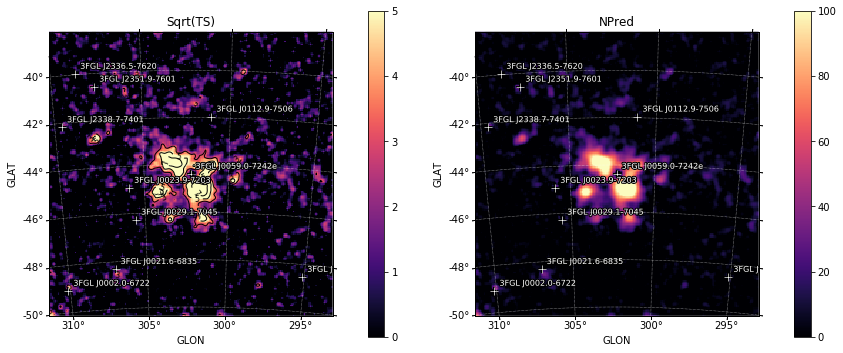

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_postfit['npred'],roi=gta.roi).plot(vmin=0,vmax=100,subplot=122,cmap='magma')
plt.gca().set_title('NPred')
gta.load_roi('initial')

Looking to the TSmap it is quite clear that the model does not fit sufficiently well the data.

# Residual Map

residmap() calculates the residual between smoothed data and model maps. Whereas a TS map is only sensitive to positive deviations with respect to the model, residmap() is sensitive to both positive and negative residuals and therefore can be useful for assessing the model goodness-of-fit. 

2018-02-28 08:29:57 INFO    GTAnalysis.residmap(): Generating residual maps
2018-02-28 08:29:57 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-02-28 08:30:02 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-02-28 08:30:06 INFO    GTAnalysis.residmap(): Finished residual maps
2018-02-28 08:30:07 INFO    GTAnalysis.residmap(): Execution time: 9.92 s


Text(0.5,1,u'Excess')

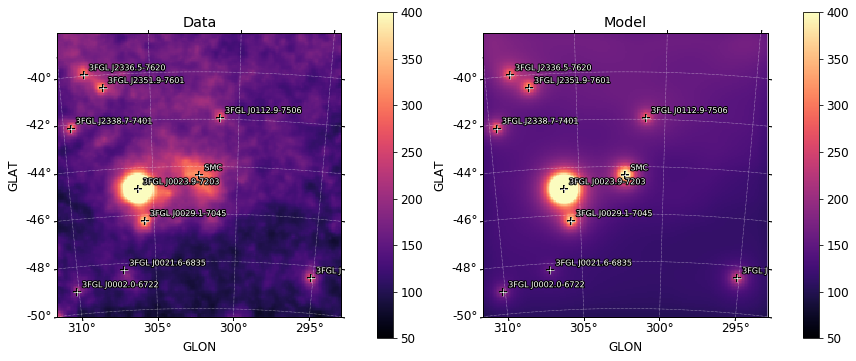

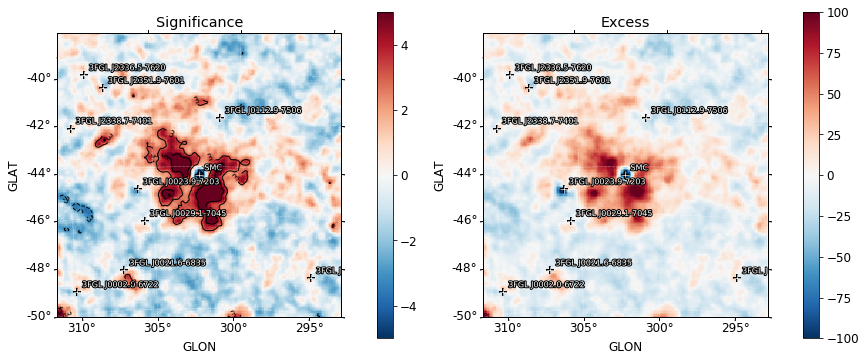

In [22]:
resid = gta.residmap('SMC_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0},write_fits=True,write_npy=True,make_plots=True)
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

# Source Localization

The localize() method can be used to spatially localize a source. Localization is performed by scanning the likelihood surface in source position in a local patch around the nominal source position. The fit to the source position proceeds in two iterations:

TS Map Scan: Obtain a first estimate of the source position by generating a likelihood map of the region using the tsmap method. In this step all background parameters are fixed to their nominal values. The size of the search region used for this step is set with the dtheta_max parameter.
Likelihood Scan: Refine the position of the source by performing a scan of the likelihood surface in a box centered on the best-fit position found in the first iteration. The size of the search region is set to encompass the 99% positional uncertainty contour. This method uses a full likelihood fit at each point in the likelihood scan and will re-fit all free parameters of the model.
If a peak is found in the search region and the positional fit succeeds, the method will update the position of the source in the model to the new best-fit position.

In [23]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
localfornax = gta.localize(gta.roi.sources[0].name, update=True, make_plots=True)
gta.print_model()

2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0021.6-6835     : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2351.9-7601     : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J2338.7-7401     : ['Prefactor', 'Index']
2018-02-28 08:30:26 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0146.4-6746     : ['Prefactor', 'Index']
2018-02-28 08

The SMC is relocalized at 0.07deg.

In [28]:
print localfornax['glon']
print localfornax['glat']
print localfornax['pos_r68']
print localfornax['pos_r95']
print localfornax['pos_r99']
print localfornax['pos_err_semimajor']
print localfornax['pos_err_semiminor']
print localfornax['dloglike_loc']

302.344991419
-44.3826189081
0.06760339023817087
0.10909829641687822
0.1352802424651775
0.06774520659180956
0.02933124815644639
1.94365053698


# Extension Fitting

The extension() method executes a source extension analysis for a given source by computing a likelihood ratio test with respect to the no-extension (point-source) hypothesis and a best-fit model for extension. The best-fit extension is found by performing a likelihood profile scan over the source width (68% containment) and fitting for the extension that maximizes the model likelihood. Currently this method supports two models for extension: a 2D Gaussian (RadialGaussian) or a 2D disk (RadialDisk).

By default the method will fix all background parameters before performing the extension fit. One can leave background parameters free by setting free_background=True.

In [29]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
extensionfornax = gta.extension(gta.roi.sources[0].name,update=True,make_plots=True,sqrt_ts_threshold=3.0,spatial_model='RadialGaussian')
gta.print_model()

2018-02-28 08:35:39 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-02-28 08:35:39 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Prefactor', 'Index']
2018-02-28 08:35:39 INFO    GTAnalysis.free_source(): Fixing parameters for isodiff               : ['Normalization']
2018-02-28 08:35:39 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.069  20.228   1.8e-06   3.12    288.87       385.1     
3FGL J0112.9-7506      2.572   1.363   2.4e-06   2.05    158.80       147.7     
3FGL J0023.9-7203      2.662   0.623  9.89e-06   2.73   5183.27      1831.2     
3FGL J0029.1-7045      3.008   0.475  2.12e-06   2.36    265.89       243.4     
3FGL J0021.6-6835      5.122   1.376  1.99e-07   3.03      8.50        39.9     
3FGL J2351.9-7

In this specific case SMC is found to be extended with TSext=371 and with an angular extension of 1.19\pm0.07deg.

In [32]:
print extensionfornax['ext']
print extensionfornax['ext_err_hi']
print extensionfornax['ext_err_lo']
print extensionfornax['ext_err']
print extensionfornax['ext']
print extensionfornax['ext_ul95']
print extensionfornax['ts_ext']

1.19796819945
0.06506584392900572
0.05956675393935651
0.062316298934181114
1.19796819945
1.30544942567
437.26190637


# Source Finding

find_sources() is an iterative source-finding algorithm that uses peak detection on a TS map to find new source candidates. The procedure for adding new sources at each iteration is as follows:

* Generate a TS map for the test source model defined with the model argument.
* Identify peaks with sqrt(TS) > sqrt_ts_threshold and an angular distance of at least min_separation from a higher amplitude peak in the map.
* Order the peaks by TS and add a source at each peak starting from the highest TS peak. Set the source position by fitting a 2D parabola to the log-likelihood surface around the peak maximum. After adding each source, re-fit its spectral parameters.
* Add sources at the N highest peaks up to N = sources_per_iter.

Source finding is repeated up to max_iter iterations or until no peaks are found in a given iteration. Sources found by the method are added to the model and given designations PS JXXXX.X+XXXX according to their position in celestial coordinates.

In [40]:
gta.free_sources()
model = {'Index' : 2.0, 'SpatialModel' : 'PointSource'}
findsource26 = gta.find_sources(model=model,sqrt_ts_threshold=5,min_separation=0.2,tsmap_fitter='tsmap')

2018-02-28 09:01:00 INFO    GTAnalysis.find_sources(): Starting.
2018-02-28 09:01:00 INFO    GTAnalysis.tsmap(): Generating TS map
2018-02-28 09:01:06 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-02-28 09:02:02 INFO    GTAnalysis.tsmap(): Finished TS map
2018-02-28 09:02:02 INFO    GTAnalysis.tsmap(): Execution time: 61.83 s
2018-02-28 09:02:02 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0103.0-7052
ts: 30.531501
2018-02-28 09:02:03 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0046.5-7049
ts: 27.563744
2018-02-28 09:02:03 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0121.3-7217
ts: 26.732409
2018-02-28 09:02:03 INFO    GTAnalysis.add_source(): Adding source PS J0103.0-7052
2018-02-28 09:02:07 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0103.0-7052       : ['Prefactor']
2018-02-28 09:02:07 INFO    GTAnalysis.add_source(): Adding source PS J0046.5-7049
2018-02-28 09:02

In [41]:
gta.print_model()
gta.write_roi('SMC_relext_TS25',make_plots=True,save_model_map=True)

2018-02-28 09:08:58 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
SMC                    0.069  47.548  1.01e-05   2.46    691.68      1327.9    *
PS J0040.5-7158        1.537   2.487  9.22e-07   2.22     47.08        83.5    *
PS J0121.3-7217        1.809   0.870  8.91e-07   1.93     28.12        38.8     
PS J0103.0-7052        1.923   3.643  5.21e-07   2.70     40.81        86.7     
PS J0046.5-7049        2.128   1.063  7.22e-07   2.03     27.47        42.3     
3FGL J0112.9-7506      2.572   1.363  2.46e-06   2.04    163.91       148.3    *
3FGL J0023.9-7203      2.662   0.595  9.75e-06   2.71   5156.54      1795.0    *
3FGL J0029.1-7045      3.008   0.474  2.16e-06   2.35    274.37       243.7    *
PS J0000.5-7353        4.267   2.165  9.16e-07   2.17     56.03        75.2    *
3FGL J0021.6-6835      5.122   1.844  2.41e-07   3.09 

2018-02-28 09:12:12 INFO    GTAnalysis.tsmap(): Generating TS map
2018-02-28 09:12:18 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-02-28 09:13:17 INFO    GTAnalysis.tsmap(): Finished TS map
2018-02-28 09:13:17 INFO    GTAnalysis.tsmap(): Execution time: 64.71 s


Text(0.5,1,u'NPred')

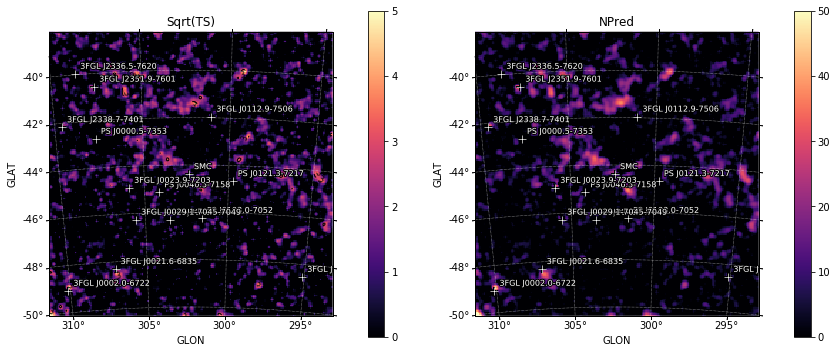

In [43]:
tsmap_postfit = gta.tsmap(prefix='TSmap_relext_TS25',make_plots=True,write_fits=True,write_npy=True)
%matplotlib inline
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')
ROIPlotter(tsmap_postfit['npred'],roi=gta.roi).plot(vmin=0,vmax=50,subplot=122,cmap='magma')
plt.gca().set_title('NPred')

2018-02-28 08:55:01 INFO    GTAnalysis.residmap(): Generating residual maps
2018-02-28 08:55:01 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-02-28 08:55:06 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-02-28 08:55:11 INFO    GTAnalysis.residmap(): Finished residual maps
2018-02-28 08:55:11 INFO    GTAnalysis.residmap(): Execution time: 10.33 s


Text(0.5,1,u'Excess')

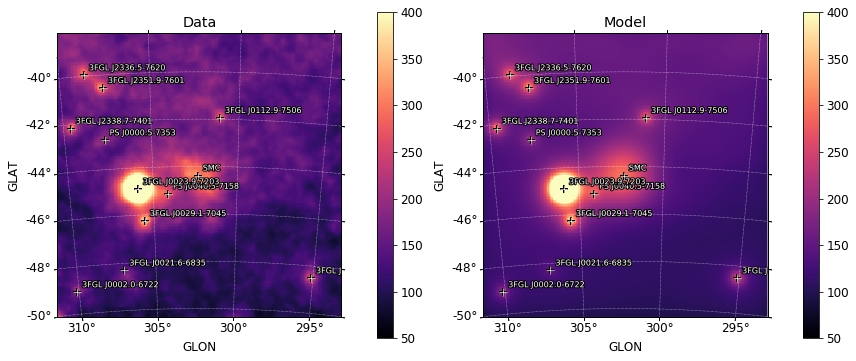

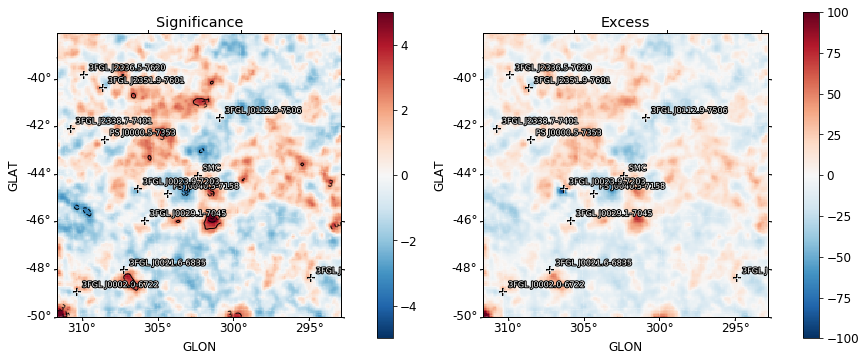

In [39]:
resid = gta.residmap('TSmap_relext_TS26',model={'SpatialModel' : 'PointSource', 'Index' : 2.0},write_fits=True,write_npy=True,make_plots=True)
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=50,vmax=400,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

# Sed Analysis

The sed() method computes a spectral energy distribution (SED) by performing independent fits for the flux normalization of a source in bins of energy. The normalization in each bin is fit using a power-law spectral parameterization with a fixed index. The value of this index can be set with the bin_index parameter or allowed to vary over the energy range according to the local slope of the global spectral model (with the use_local_index parameter).

The free_background, free_radius, and cov_scale parameters control how nuisance parameters are dealt with in the fit. By default the method will fix the parameters of background components ROI when fitting the source normalization in each energy bin (free_background=False). Setting free_background=True will profile the normalizations of all background components that were free when the method was executed. In order to minimize overfitting, background normalization parameters are constrained with priors taken from the global fit. The strength of the priors is controlled with the cov_scale parameter. A larger (smaller) value of cov_scale applies a weaker (stronger) constraint on the background amplitude. Setting cov_scale=None performs an unconstrained fit without priors.


In [45]:
gta.free_sources(free=False)
gta.print_model()
gta.free_sources(skydir=gta.roi[gta.roi.sources[0].name].skydir,distance=[3.0],free=True)
gta.print_model()
sedsmc = gta.sed(gta.roi.sources[0].name, bin_index=2.2, outfile='sedSMC.fits', loge_bins=None,write_npy=True,write_fits=True,make_plots=True)

2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for SMC                   : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0040.5-7158       : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0121.3-7217       : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0103.0-7052       : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0046.5-7049       : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0112.9-7506     : ['Prefactor', 'Index']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0023.9-7203     : ['norm', 'alpha', 'beta']
2018-02-28 09:16:24 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J0029.1-7045     : ['Prefactor', 'Index']
2018-02-28 09

In [57]:
print sedsmc['e_min']
print sedsmc['e_max']
print sedsmc['e_ref']
print sedsmc['flux']
print sedsmc['eflux']
print sedsmc['e2dnde']
print sedsmc['dnde_ul95']
print sedsmc['ts']

[1.00000000e+03 1.33955330e+03 1.79444437e+03 2.40375389e+03
 3.21995647e+03 4.31330332e+03 5.77803276e+03 7.73998288e+03
 1.03681196e+04 1.38886489e+04 1.86050140e+04 2.49224079e+04
 3.33848939e+04 4.47208449e+04 5.99073350e+04 8.02490685e+04
 1.07497905e+05 1.44002489e+05 1.92899011e+05 2.58398507e+05
 3.46138574e+05 4.63681747e+05 6.21126416e+05 8.32031943e+05
 1.11455114e+06 1.49303504e+06]
[1.33955330e+03 1.79444437e+03 2.40375389e+03 3.21995647e+03
 4.31330332e+03 5.77803276e+03 7.73998288e+03 1.03681196e+04
 1.38886489e+04 1.86050140e+04 2.49224079e+04 3.33848939e+04
 4.47208449e+04 5.99073350e+04 8.02490685e+04 1.07497905e+05
 1.44002489e+05 1.92899011e+05 2.58398507e+05 3.46138574e+05
 4.63681747e+05 6.21126416e+05 8.32031943e+05 1.11455114e+06
 1.49303504e+06 2.00000002e+06]
[1.15739073e+03 1.55040443e+03 2.07687329e+03 2.78208247e+03
 3.72674777e+03 4.99223476e+03 6.68744156e+03 8.95818444e+03
 1.19999656e+04 1.60747786e+04 2.15332707e+04 2.88449639e+04
 3.86393667e+04 5.176

[4.74408476e-06 4.73674690e-06 4.06097583e-06 3.55582645e-06
 3.30082492e-06 4.17553934e-06 3.13193814e-06 2.79613030e-06
 2.79227586e-06 2.66792946e-06 2.19389943e-06 2.10139826e-06
 4.82067631e-07 1.18001557e-06 2.46584258e-06 3.38097041e-06
 1.32994103e-06 8.03725162e-06 2.36251257e-06 3.76056967e-06
 4.28788247e-06 5.84503470e-06 8.02042110e-06 2.00482487e-05
 1.76556410e-05 2.96545280e-05]


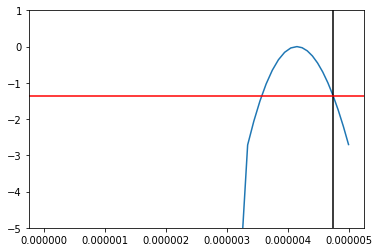

In [48]:
# E^2 x Differential flux ULs in each bin in units of MeV cm^{-2} s^{-1}
print sedsmc['e2dnde_ul95']

e2dnde_scan = sedsmc['norm_scan']*sedsmc['ref_e2dnde'][:,None]

plt.figure()
plt.plot(e2dnde_scan[0],sedsmc['dloglike_scan'][0]-np.max(sedsmc['dloglike_scan'][0]))
plt.gca().set_ylim(-5,1)
plt.gca().axvline(sedsmc['e2dnde_ul95'][0],color='k')
plt.gca().axhline(-2.71/2.,color='r')

(1e-07, 1e-05)

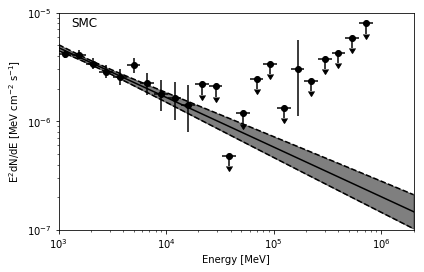

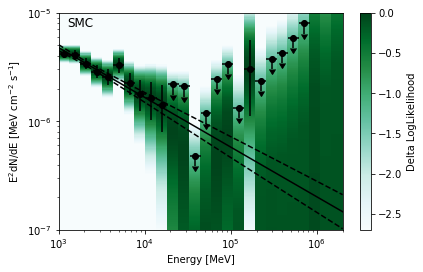

In [55]:
fig = plt.figure(figsize=(14,4))
ylim=[1E-7,1E-5]
fig.add_subplot(121)
SEDPlotter(sedsmc).plot()
plt.gca().set_ylim(ylim)

fig = plt.figure(figsize=(14,4))

fig.add_subplot(121)
SEDPlotter(sedsmc).plot(showlnl=True,ylim=ylim)
plt.gca().set_ylim(ylim)

# Light curve

lightcurve() fits the charateristics of a source (flux, TS, etc.) in a sequence of time bins. This method uses the data selection and model of a baseline analysis (e.g. the full mission) and is therefore restricted to analyzing time bins that are encompassed by the time selection of the baseline analysis. In general when using this method it is recommended to use a baseline time selection of at least several years or more to ensure the best characterization of background sources in the ROI.

When fitting a time bin the method will initialize the model to the current parameters of the baseline analysis. The parameters to be refit in each time bin may be controlled with free_background, free_sources, free_radius, free_params, and shape_ts_threshold options.

By default the lightcurve method will run an end-to-end analysis in each time bin using the same processing steps as the baseline analysis. Depending on the data selection and ROI size each time bin may take 10-15 minutes to process. There are several options which can be used to reduce the lightcurve computation time. The multithread option splits the analysis of time bins across multiple cores.

The use_scaled_srcmap option generates an approximate source map for each time bin by scaling the source map of the baseline analysis by the relative exposure.

In [58]:
lc = gta.lightcurve('SMC', free_radius=3.0, nbins=10, multithread=True, nthread=10, use_scaled_srcmap=True)

2018-02-28 09:28:06 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for SMC
2018-02-28 09:28:11 INFO    lightcurve_239557417_266901117 GTAnalysis._process_lc_bin(): Fitting time range 239557417 266901117
2018-02-28 09:28:11 INFO    lightcurve_266901117_294244817 GTAnalysis._process_lc_bin(): Fitting time range 266901117 294244817
2018-02-28 09:28:11 INFO    lightcurve_294244817_321588517 GTAnalysis._process_lc_bin(): Fitting time range 294244817 321588517
2018-02-28 09:28:11 INFO    lightcurve_321588517_348932217 GTAnalysis._process_lc_bin(): Fitting time range 321588517 348932217
2018-02-28 09:28:12 INFO    lightcurve_348932217_376275917 GTAnalysis._process_lc_bin(): Fitting time range 348932217 376275917
2018-02-28 09:28:12 INFO    lightcurve_376275917_403619617 GTAnalysis._process_lc_bin(): Fitting time range 376275917 403619617
2018-02-28 09:28:12 INFO    lightcurve_403619617_430963317 GTAnalysis._process_lc_bin(): Fitting time range 403619617 430963317
2018-02-28 09:28:12 IN

2018-02-28 09:38:55 INFO    lightcurve_376275917_403619617 GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/lightcurve_376275917_403619617/base_00.xml...
2018-02-28 09:38:55 INFO    lightcurve_266901117_294244817 GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/lightcurve_266901117_294244817/base_00.xml...
2018-02-28 09:38:57 INFO    lightcurve_294244817_321588517 GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/lightcurve_294244817_321588517/base_00.xml...
2018-02-28 09:38:57 INFO    lightcurve_239557417_266901117 GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/lightcurve_239557417_266901117/base_00.xml...
2018-02-28 09:38:57 INFO    lightcurve_403619617_430963317 GTBinnedAnalysis.write_xml(): Writing /u/gl/mdimauro/kipac/workdir/fermipytutorial/SMC/lightcurve_403619617_430963317/base_00.xml...
2018-02-28 09:38:59 INFO    lightcurve_3

In [63]:
print lc['tmin']
print lc['tmax']
print lc['fit_success']
print lc['ts_var']
print lc['flux']
print lc['eflux']
print lc['flux_ul95']

[2.39557417e+08 2.66901117e+08 2.94244817e+08 3.21588517e+08
 3.48932217e+08 3.76275917e+08 4.03619617e+08 4.30963317e+08
 4.58307017e+08 4.85650717e+08]
[2.66901117e+08 2.94244817e+08 3.21588517e+08 3.48932217e+08
 3.76275917e+08 4.03619617e+08 4.30963317e+08 4.58307017e+08
 4.85650717e+08 5.12994417e+08]
[ True  True  True  True  True  True  True  True  True  True]
11.24840526985385
[3.32033882e-09 2.77384367e-09 3.51990560e-09 2.97034508e-09
 3.24973429e-09 3.22673216e-09 3.03199868e-09 3.32289496e-09
 4.14794603e-09 3.02019493e-09]
[9.24939595e-06 8.69618438e-06 8.45495678e-06 9.14678010e-06
 8.72775350e-06 8.93578499e-06 1.26806189e-05 1.18695180e-05
 1.66370299e-05 9.02178038e-06]
[4.21737769e-09 3.52603681e-09 4.28755267e-09 3.72329763e-09
 4.02997768e-09 4.00408636e-09 3.87601158e-09 4.14181993e-09
 4.94567050e-09 3.79167695e-09]


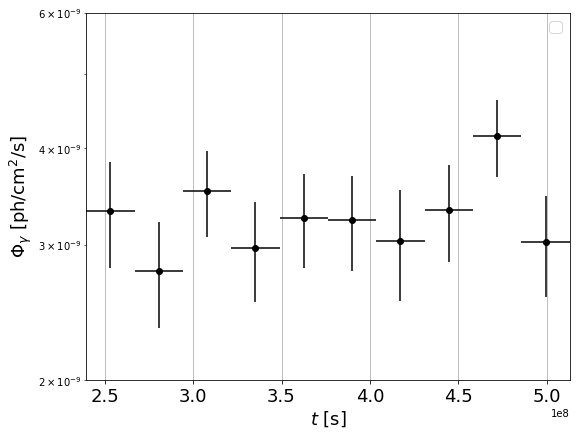

In [70]:
fig = plt.figure(figsize=(8,6))
plt.errorbar((lc['tmin']+lc['tmax'])/2., lc['flux'], yerr=lc['flux_err'], xerr=(lc['tmin']-lc['tmax'])/2., fmt="o", color="black")
plt.ylabel(r'$\Phi_{\gamma}$ [ph/cm$^2$/s]', fontsize=18)
plt.xlabel(r'$t$ [s]', fontsize=18)
plt.axis([lc['tmin'][0],lc['tmax'][len(lc['tmax'])-1],2e-9,6e-9], fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.yscale('log')
plt.xscale('linear')
plt.legend(loc=1,prop={'size':16},numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)
plt.show()